# **Welcome**

[Original Google Collab Notebook Link](https://colab.research.google.com/drive/1wDifY2AoJ8N4HlNrQ7QN9rTFWFmJjp7k?usp=sharing)

Made By Mert Kalkancı for Akasu Plant Disease Detection Project

[Github Page Link](https://github.com/MertKalkanci/Plant-Leaf-Selection-On-Image)

[LICENSED UNDER MIT LICENSE](https://github.com/MertKalkanci/Plant-Leaf-Selection-On-Image/blob/main/LICENSE)

Also it would be nice if you credit me :)

# **To Start Install PlantCV**
(You need to restart runtime in Google Collab)

In [ ]:
!pip install --upgrade plantcv pillow

# **0. Import Necessary Libraries**

In [ ]:
import sys, traceback
import cv2
import os
import re
import numpy as np
import argparse
import string
from matplotlib import pyplot as plt
from plantcv import plantcv as pcv
from PIL import Image

# **1. Configure Settings**

In [ ]:
mask_type_is_b = True
treshold = 160
input_file = '/content/input_rasberry.png'
output_dir = '/content/output/'

output_image_size = [128,128]

# **2. Import Image**

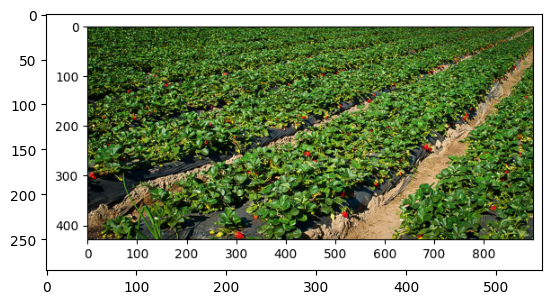

(285, 552, 3)


In [ ]:
pcv.params.debug="plot" #set debug mode
img, path, filename = pcv.readimage(input_file)


img_size = img.shape

print(img_size)

if np.average(img) < 50:
  pcv.fatal_error("Night Image")
else:
  pass


 # **3. Mask & Select Bottom Left Part Of Plant**

###3.1 **Mask Image With LAB Channels**

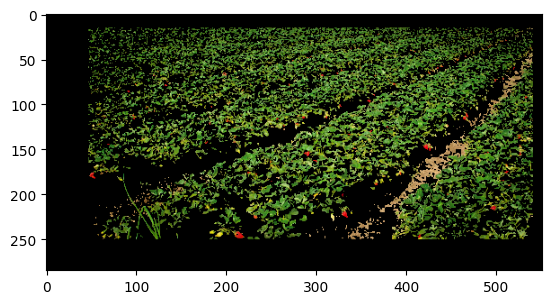

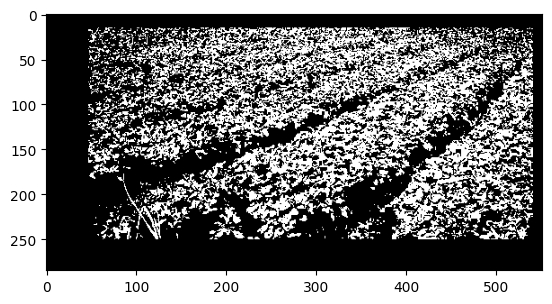

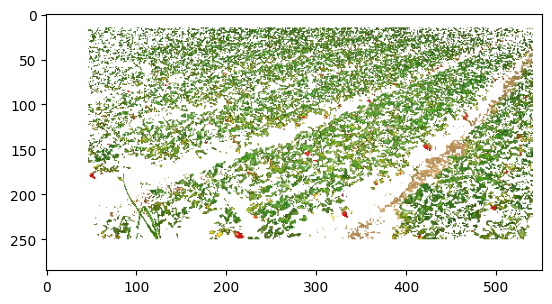

In [ ]:
if mask_type_is_b:
  mask, masked_img = pcv.threshold.custom_range(img=img, lower_thresh=[0,0,treshold],
                                              upper_thresh=[255,255,255], channel='LAB')
else:
  mask, masked_img = pcv.threshold.custom_range(img=img, lower_thresh=[treshold,0,0],
                                              upper_thresh=[255,255,255], channel='LAB')
masked = pcv.apply_mask(img=img, mask=mask, mask_color='white')

###3.2 **Apply Roi & Select Bottom Right Part**

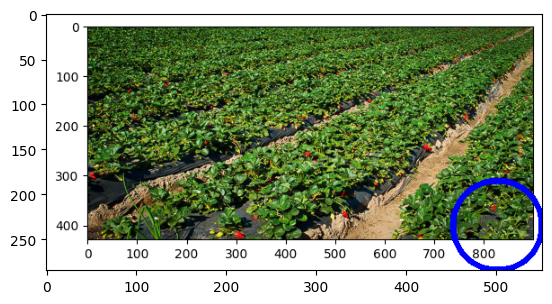

In [ ]:
rois, roi_hierarchy = pcv.roi.circle(img, x=(img_size[1] - 50), y=(img_size[0] - 50),r=50)

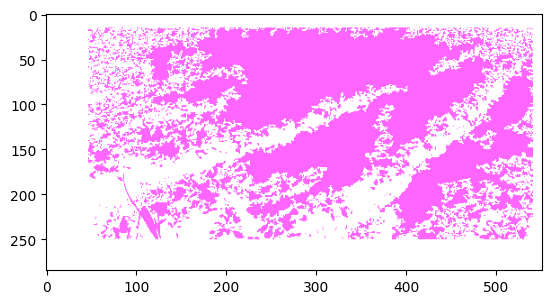

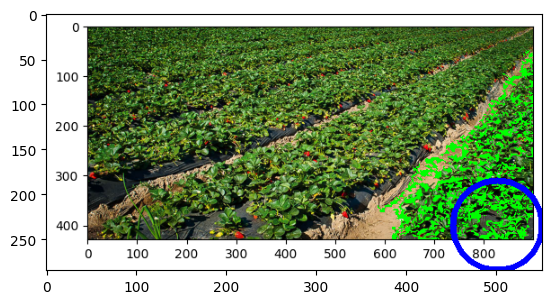

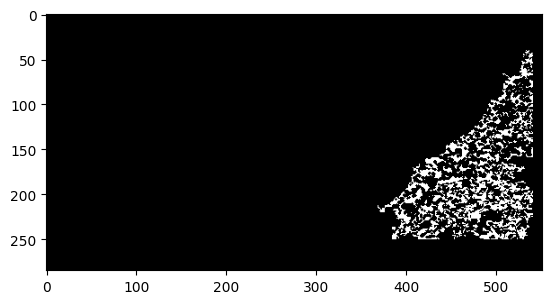

In [ ]:
id_objects, obj_hierarchy = pcv.find_objects(img=masked,mask=mask)

roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img, rois, roi_hierarchy,
                                                              id_objects, obj_hierarchy, 'partial')

pcv.print_image(img=kept_mask, filename=f'{output_dir}mask.png')

# **4. Apply Watershred Segmentation**

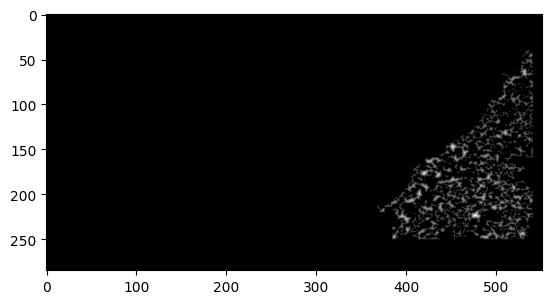

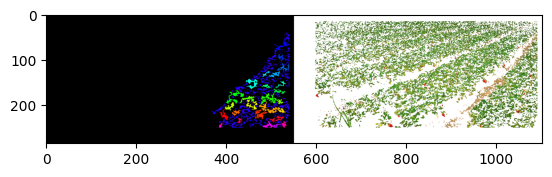

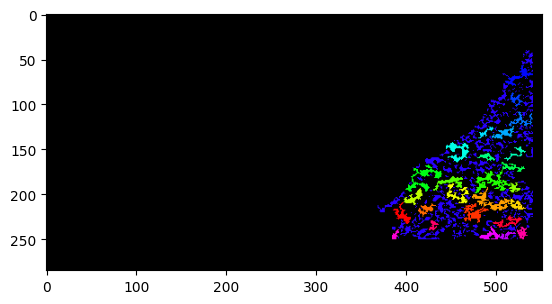

In [ ]:
analysis_images = pcv.watershed_segmentation(rgb_img=masked, mask=kept_mask, distance=15, label="")

height, width, channels = analysis_images.shape
analysis_images = analysis_images[0:height,0:int(width/2)]

pcv.print_image(img=analysis_images, filename=f'{output_dir}mask.png')
pcv.plot_image(analysis_images)

In [ ]:
pcv.params.debug="None" #change debug mode to prevent every log

# **5. Function That Exports Leave With Threshold**

In [ ]:
def try_to_extract_leaf_with_thresh(lower_thresh,upper_thresh):

  is_empty = True

  mask_thresh = cv2.inRange(analysis_images, lower_thresh, upper_thresh)

  # change all non-specified color to white
  result = analysis_images.copy()
  result[mask_thresh!=255] = (0, 0, 0)

  gray_mask = pcv.rgb2gray(rgb_img=result)
  masked_final = pcv.apply_mask(img=masked_img, mask=gray_mask, mask_color="black")

  list_y,list_x = [],[]

  for i in range(len(masked_final)):

    for j in range(len(masked_final[i])):

      if (masked_final[i][j] != [0,0,0]).any(): #check is there any color on masked_final to cut image and specify is that empty or not
        is_empty = False

        list_y.append(i)
        list_x.append(j)

  if is_empty:
    return 'EMPTY'

  else:
    list_y = np.array(list_y)
    list_x = np.array(list_x)

    y1 = np.amin(list_y)
    x1 = np.amin(list_x)
    y2 = np.max(list_y)
    x2 = np.max(list_x)

    height, width, channels = masked_final.shape

    output = cv2.resize(masked_final[y1:y2,x1:x2], output_image_size, interpolation= cv2.INTER_LINEAR)

    return output


# **6. Extraction Of All Leaves From Watershredded Mask Image**

###6.1 A **Threshold Map Method 1 - Getting Colors & Threshing (Recommended)**

In [ ]:
lower=np.empty([1,3])
upper=np.empty([1,3])
color_map=np.empty([1,3])

for i in range(len(analysis_images)):

  for j in range(len(analysis_images[i])):
      if (analysis_images[i][j] != [0,0,0]).any():

          #if len(color_map) > 0: # if not has any color never checks colors inside

          has_the_color = False

          for color in color_map: #check every color
              if (analysis_images[i][j] == color).all():
                      has_the_color = True

          if not has_the_color:
               color_map = np.append(color_map, [analysis_images[i][j]], axis=0)

          #else:
          #  print('first')
          #  color_map = np.append(color_map, [analysis_images[i][j]], axis=0)

for color in color_map:
  print(color)
  lower = np.append(lower, [[color[0], color[1], color[2]]], axis=0)
  upper = np.append(lower, [[color[0] + 1, color[1] + 1, color[2] + 1]], axis=0)

[256.   1. 192.]
[255.   0.  40.]
[255.   7.   0.]
[255.  61.   0.]
[255. 115.   0.]
[255. 169.   0.]
[255. 223.   0.]
[232. 255.   0.]
[183. 255.   0.]
[129. 255.   0.]
[ 75. 255.   0.]
[ 21. 255.   0.]
[  0. 255.  32.]
[  0. 255.  86.]
[  0. 255. 139.]
[  0. 255. 241.]
[  0. 159. 255.]
[  0. 255. 188.]
[  0. 213. 255.]
[  0.   1. 255.]
[  0. 105. 255.]
[  0.  50. 255.]
[ 52.   0. 255.]
[106.   0. 255.]
[255.   0. 240.]
[161.   0. 255.]
[215.   0. 255.]
[255.   0. 191.]


###6.1 B **Threshold Map Method 2 - Checking Every Color (Not Recommended but shown there as an alternative)**

In [ ]:
lower=np.empty([1,3])
upper=np.empty([1,3])

#color_array = np.unique(analysis_images)

for r in range(0,12):

  for g in range(0,12):

    for b in range(0,12):
      lower = np.append(lower,[[r * 20,
                               g * 20,
                               b * 20]],
                         axis=0)
      upper = np.append(upper,[[(r+1) * 20 + 15,
                               (g+1) * 20 + 15,
                               (b+1) * 20 + 15]],
                        axis=0)

###6.2 **Show Threshold Maps**

In [ ]:
print(lower)

[[  0. 100. 200.]
 [256.   1. 192.]
 [255.   0.  40.]
 [255.   7.   0.]
 [255.  61.   0.]
 [255. 115.   0.]
 [255. 169.   0.]
 [255. 223.   0.]
 [232. 255.   0.]
 [183. 255.   0.]
 [129. 255.   0.]
 [ 75. 255.   0.]
 [ 21. 255.   0.]
 [  0. 255.  32.]
 [  0. 255.  86.]
 [  0. 255. 139.]
 [  0. 255. 241.]
 [  0. 159. 255.]
 [  0. 255. 188.]
 [  0. 213. 255.]
 [  0.   1. 255.]
 [  0. 105. 255.]
 [  0.  50. 255.]
 [ 52.   0. 255.]
 [106.   0. 255.]
 [255.   0. 240.]
 [161.   0. 255.]
 [215.   0. 255.]
 [255.   0. 191.]]


###6.3 **Extracting Leaves With Threshold Map**#

In [ ]:
leaves = np.empty([1,128,128,3])
for i in range(0,len(lower)):
  print(f'Number:{i+1}, Total:{len(lower)}')
  if try_to_extract_leaf_with_thresh(lower[i],upper[i]) != 'EMPTY':
    #pcv.plot_image(try_to_extract_leaf_with_thresh(lower[i],upper[i]))
    leaves = np.append(leaves,
                       [try_to_extract_leaf_with_thresh(lower[i],upper[i])],
                       axis=0)

Number:1, Total:29
Number:2, Total:29
Number:3, Total:29


<ipython-input-19-94392adf5588>:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Number:4, Total:29
Number:5, Total:29
Number:6, Total:29
Number:7, Total:29
Number:8, Total:29
Number:9, Total:29
Number:10, Total:29
Number:11, Total:29
Number:12, Total:29
Number:13, Total:29
Number:14, Total:29
Number:15, Total:29
Number:16, Total:29
Number:17, Total:29
Number:18, Total:29
Number:19, Total:29
Number:20, Total:29
Number:21, Total:29
Number:22, Total:29
Number:23, Total:29
Number:24, Total:29
Number:25, Total:29
Number:26, Total:29
Number:27, Total:29
Number:28, Total:29
Number:29, Total:29


# **6. Saving Leave Files**

In [ ]:
for i in range(0, len(leaves)):
  pcv.print_image(img=leaves[i], filename=f'{output_dir}OUTPUT_{i}.png')

# **7. Showing Leave Images**

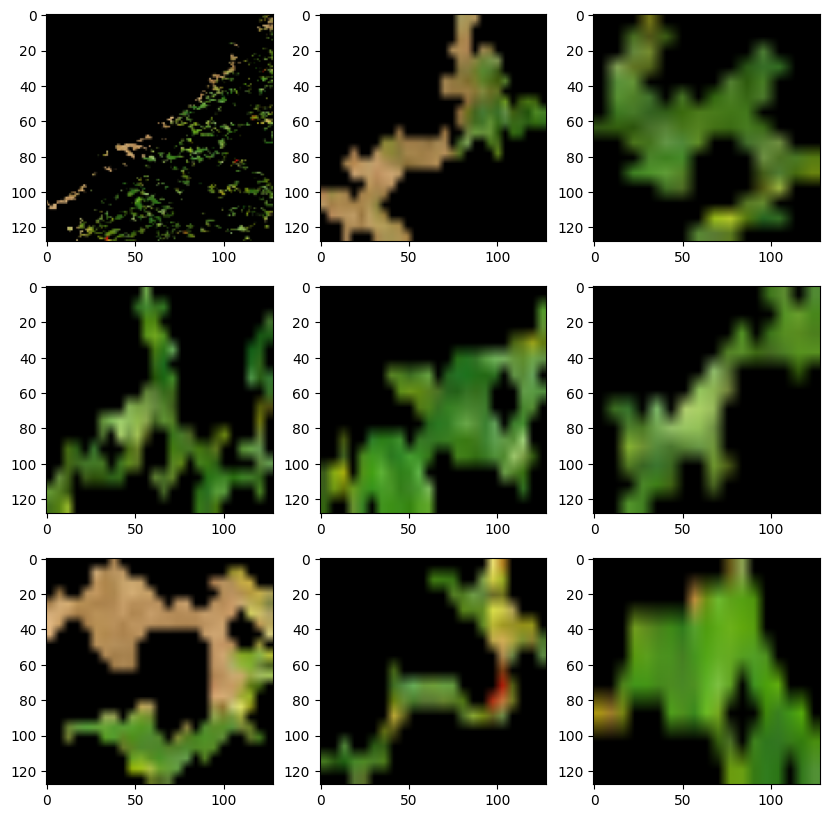

In [ ]:
fig = plt.figure(figsize=(10, 10))
columns = 3
rows = 3
for i in range(1, columns*rows+1):
    fig.add_subplot(rows, columns, i)
    rgb = cv2.cvtColor(cv2.imread(f'{output_dir}OUTPUT_{i}.png'), cv2.COLOR_BGR2RGB)# converting BGR to RGB
    plt.imshow(rgb/255)
plt.show()